# BM-dataset: GNN prediction of the adsorption energy compared to DFT

This notebook reproduces the final results shown in the paper (parity plot in Figure4).

In [1]:
import sys, os
sys.path.insert(0, '../src')
sys.path.insert(0, '../src/gnn_eads')
import pandas as pd
import numpy as np
from pymatgen.io.vasp import Outcar
from torch_geometric.loader import DataLoader
import cycler
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.font_manager import FontProperties
legend_font = FontProperties(family='Arial', style='normal', size=9)
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.metrics import r2_score

from gnn_eads.functions import get_mean_std_from_model, contcar_to_graph, get_graph_conversion_params
from gnn_eads.graph_tools import extract_adsorbate, get_number_atoms
from gnn_eads.nets import PreTrainedModel
from gnn_eads.constants import MOL_ELEM, ENCODER, ELEMENT_LIST, FULL_ELEM_LIST

/home/smorandi/anaconda3/envs/GNN/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/smorandi/anaconda3/envs/GNN/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# Load pretrained GNN from models folder
MODEL_NAME = "best_13Dec2022_hypopt"
MODEL_PATH = "/home/smorandi/teklahome/{}".format(MODEL_NAME)  
model = PreTrainedModel(MODEL_PATH)
print(model)

# Create a folder for the specific GNN model tested on the BM_dataset
os.mkdir("../performance_BMdataset/{}".format(MODEL_NAME))


GNN pretrained model for DFT ground state energy prediction.
Creation date: 2022-12-14 13:08:57.419099
Model path: /home/smorandi/teklahome/best_13Dec2022_hypopt
Number of parameters: 281857
Model size: 1.08MB


In [3]:
# Function for counting non-H atoms in adsorbates
CONS = [ELEMENT_LIST.index(element) for element in ["C", "O", "N", "S"]]
adsorbate_atom_counter_noH = lambda graph: int(graph.x.sum(axis=0)[CONS].sum().item())

# Raed csv with adsorption energy of the BM dataset
BM_datapath = "../data/BM_dataset"
df = pd.read_csv("../data/BM_dataset/DFT_BM.csv")
df.head()

,Label,Family,Metal,Etot_DFT,Eslab_DFT,Emol_DFT,Eads_DFT
0,ni-mol1,Biomass,ni,-699.003184,-429.518132,-266.620332,-2.864720
1,ni-mol2,Biomass,ni,-698.489544,-429.518132,-266.582128,-2.389283
2,ni-mol3,Biomass,ni,-585.906515,-429.518132,-153.601859,-2.786525
3,ni-mol4,Biomass,ni,-600.110308,-429.518132,-168.674337,-1.917839
4,ni-mol5,Biomass,ni,-593.315922,-429.518132,-162.199307,-1.598483


In [4]:
Etot_GNN, Emol_GNN, metal_presence_graph , adsorbate_atoms_noH = [], [], [], []
for sample in df.iterrows():
    # Read CONTCAR files for adsorption system and gas-phase molecule
    contcar_ads = os.path.join(BM_datapath, sample[1]["Family"], sample[1]["Label"], "CONTCAR")
    contcar_mol = os.path.join(BM_datapath, sample[1]["Family"], sample[1]["Label"].split("-")[-1], "CONTCAR")
    # Convert to graphs
    graph_ads = contcar_to_graph(contcar_ads, model.g_tol, model.g_sf, model.g_metal_2nn)
    graph_mol = contcar_to_graph(contcar_mol, model.g_tol, model.g_sf, model.g_metal_2nn)
    # Check correctness of metal presence in the adsorption graphs
    if graph_ads.num_nodes == graph_mol.num_nodes:
        metal_presence_graph.append("Wrong")
    else:
        metal_presence_graph.append("Correct")
    # Get number of non-H atoms in adsorbate
    adsorbate_atoms_noH.append(adsorbate_atom_counter_noH(graph_mol))
    # Get GNN predictions
    Etot_GNN.append(model.evaluate(graph_ads))
    Emol_GNN.append(model.evaluate(graph_mol))

df["Etot_GNN"] = Etot_GNN
df["Emol_GNN"] = Emol_GNN
df["Eads_GNN"] = df["Etot_GNN"] - df["Emol_GNN"]
df["Metal_presence_graph"] = metal_presence_graph
df["Adsorbate_atoms_noH"] = adsorbate_atoms_noH
df["Error"] = df["Eads_DFT"] - df["Eads_GNN"]
df["Error_abs"] = np.abs(df["Error"])
df["Error_per_noHatom"] = df["Error_abs"] / df["Adsorbate_atoms_noH"]
df

,Label,Family,Metal,Etot_DFT,Eslab_DFT,Emol_DFT,Eads_DFT,Etot_GNN,Emol_GNN,Eads_GNN,Metal_presence_graph,Adsorbate_atoms_noH,Error,Error_abs,Error_per_noHatom
0,ni-mol1,Biomass,ni,-699.003184,-429.518132,-266.620332,-2.864720,-271.175693,-267.681983,-3.493710,Correct,23,0.628990,0.628990,0.027347
1,ni-mol2,Biomass,ni,-698.489544,-429.518132,-266.582128,-2.389283,-270.406672,-267.681983,-2.724689,Correct,23,0.335405,0.335405,0.014583
2,ni-mol3,Biomass,ni,-585.906515,-429.518132,-153.601859,-2.786525,-155.729193,-153.906500,-1.822693,Correct,13,-0.963831,0.963831,0.074141
3,ni-mol4,Biomass,ni,-600.110308,-429.518132,-168.674337,-1.917839,-171.410084,-168.614003,-2.796081,Correct,14,0.878243,0.878243,0.062732
4,ni-mol5,Biomass,ni,-593.315922,-429.518132,-162.199307,-1.598483,-163.845563,-162.225078,-1.620485,Correct,13,0.022002,0.022002,0.001692
5,ru-mol1,Biomass,ru,-995.708889,-725.440080,-266.620332,-3.648478,-272.696153,-267.681983,-5.014170,Correct,23,1.365692,1.365692,0.059378
6,ru-mol2,Biomass,ru,-995.174450,-725.440080,-266.582128,-3.152242,-271.771689,-267.681983,-4.089706,Correct,23,0.937464,0.937464,0.040759
7,ru-mol3,Biomass,ru,-882.455468,-725.440080,-153.601859,-3.413530,-157.358717,-153.906500,-3.452217,Correct,13,0.038688,0.038688,0.002976
8,ru-mol4,Biomass,ru,-896.613084,-725.440080,-168.674337,-2.498668,-172.116090,-168.614003,-3.502087,Correct,14,1.003420,1.003420,0.071673
9,ru-mol5,Biomass,ru,-889.631857,-725.440080,-162.199307,-1.992470,-164.770239,-162.225078,-2.545161,Correct,13,0.552690,0.552690,0.042515


In [5]:
MAE = df["Error_abs"].mean()
MAE_per_noHatom = df["Error_per_noHatom"].mean()
R2 = r2_score(df["Eads_DFT"], df["Eads_GNN"])
print("MAE: {:.2f} eV".format(MAE))
print("MAE per non-H atom: {:.2f} eV".format(MAE_per_noHatom))
print("R2: {:.2f}".format(R2))

MAE: 0.65 eV
MAE per non-H atom: 0.04 eV
R2: 0.44


## Create parity plot DFT vs GNN for the adsorption energy of the BM-dataset

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

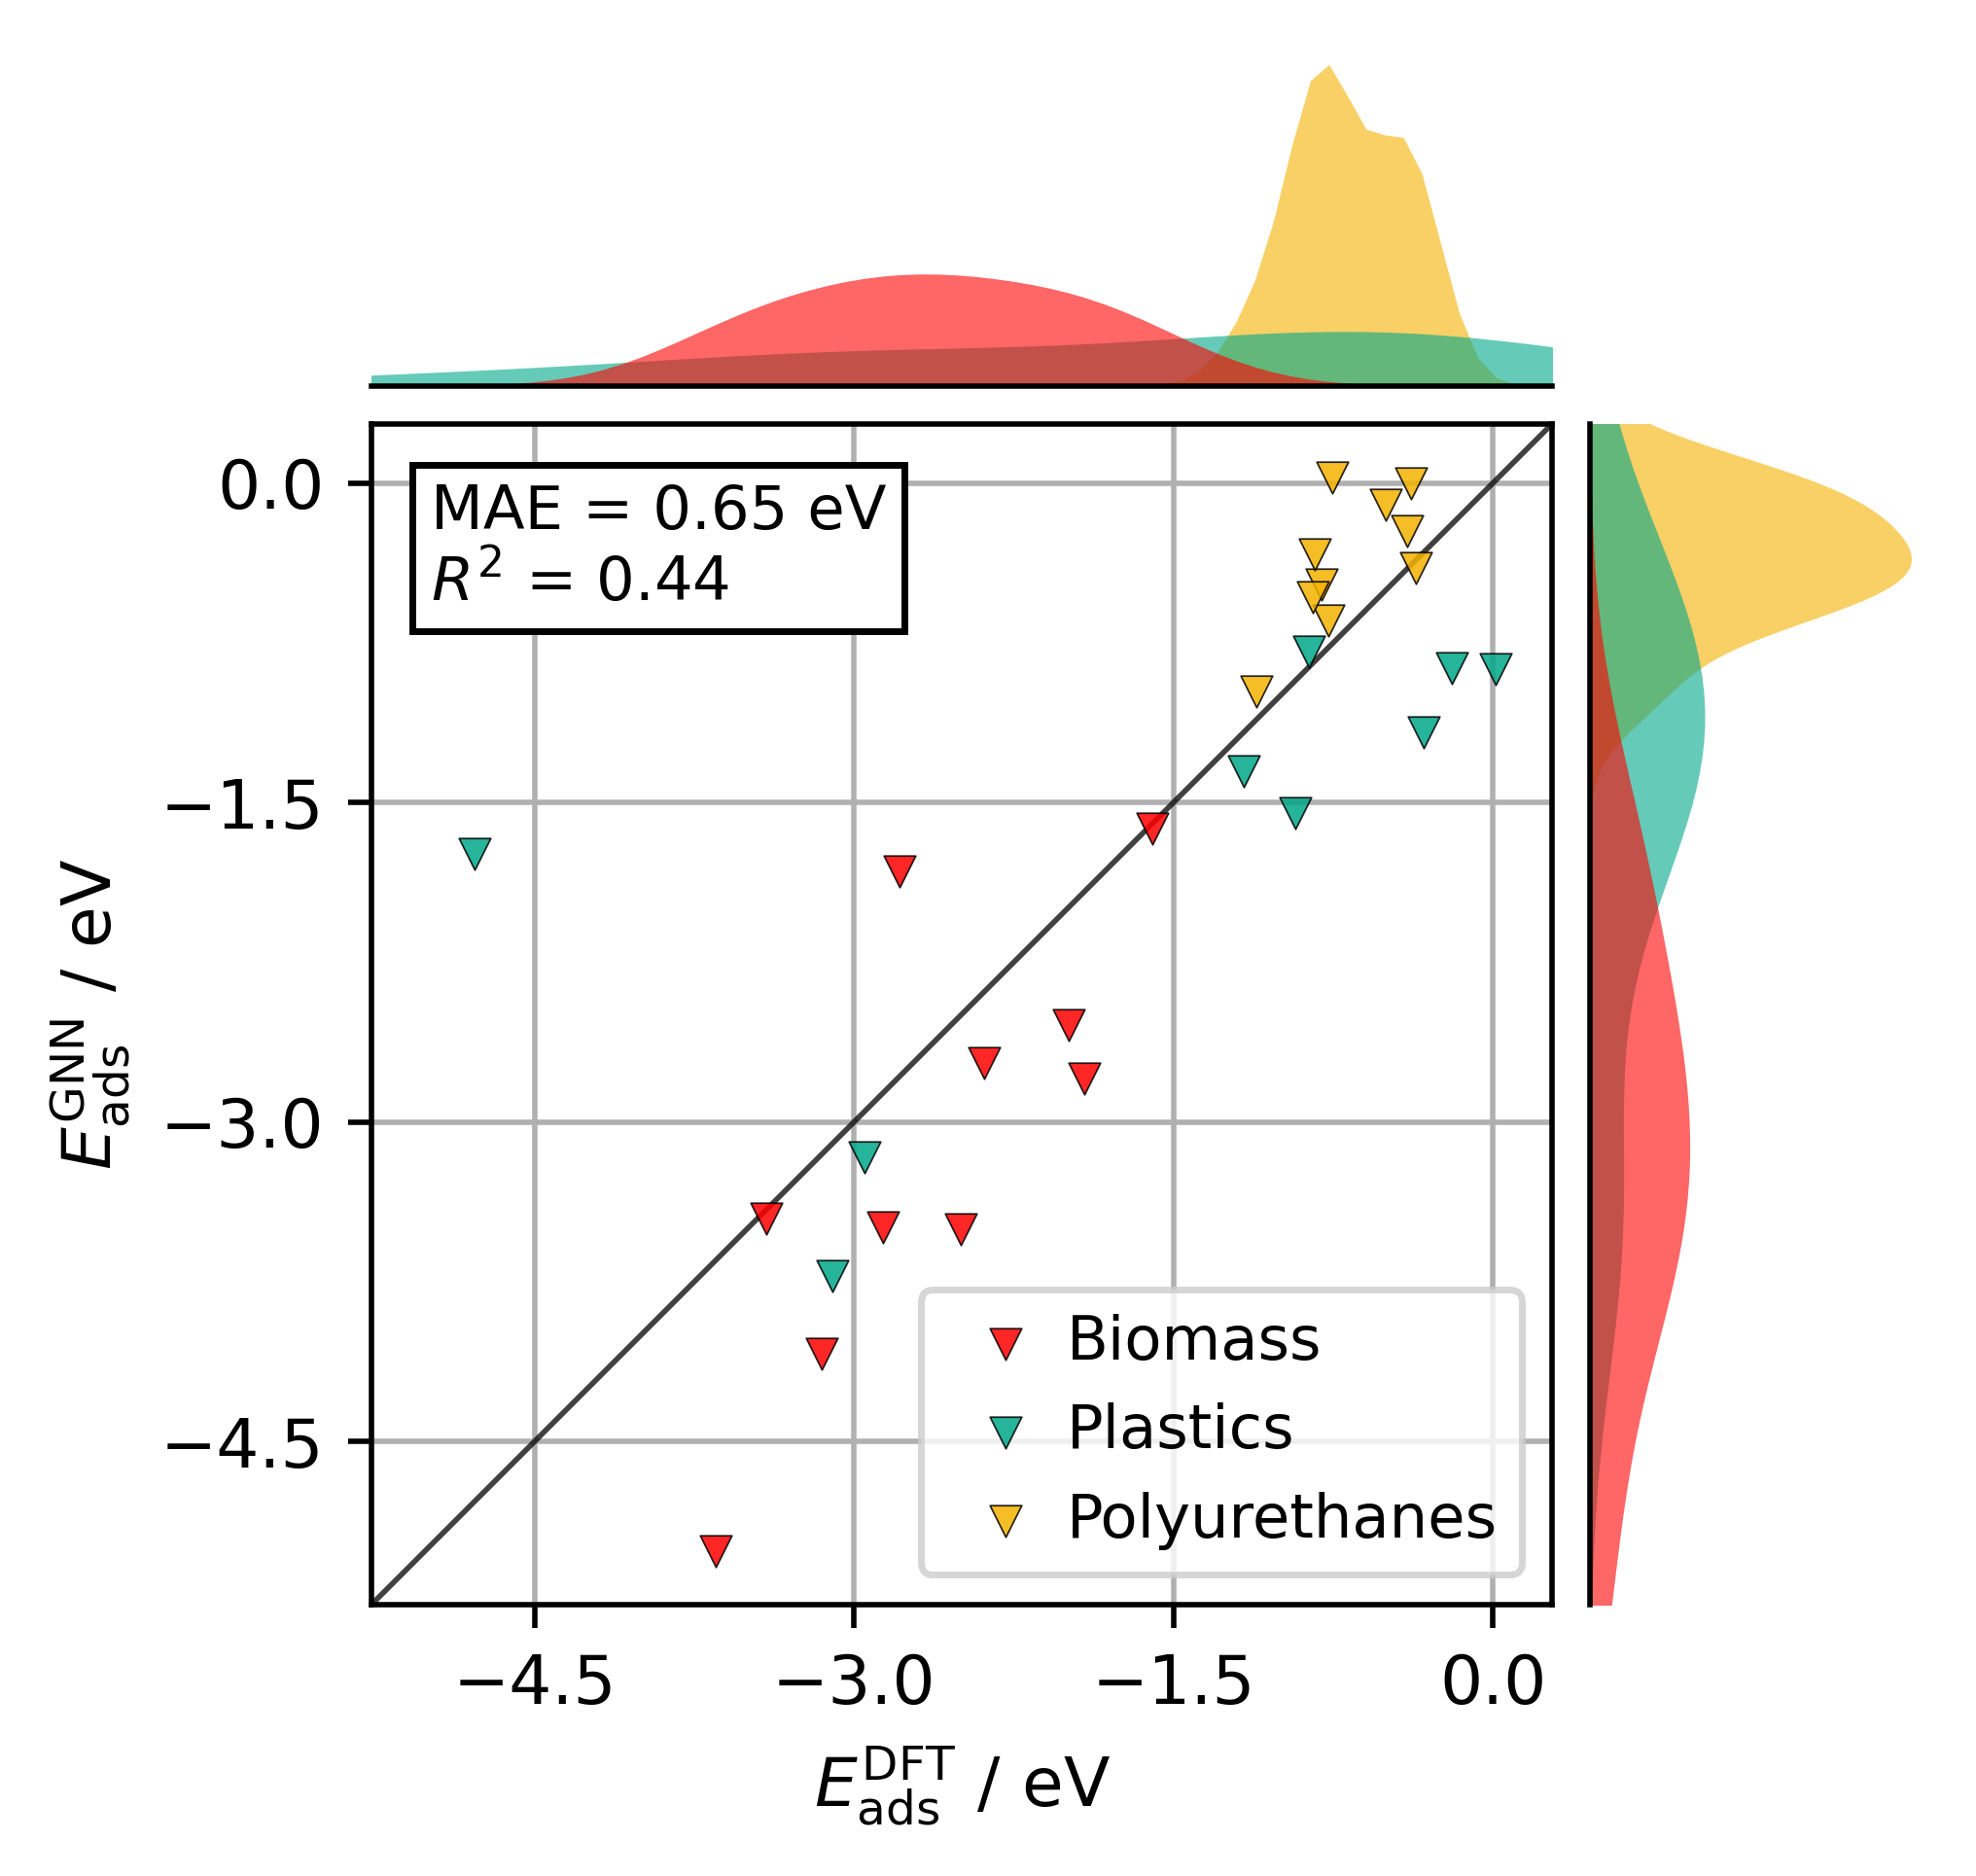

In [6]:
fig = plt.figure(figsize=(4,4), dpi=500)
params = {'mathtext.default': 'regular'}          
plt.rcParams.update(params)
gs = GridSpec(4, 4)
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax_scatter = fig.add_subplot(gs[1, 0])
ax_hist_x = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_hist_y = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

ax_scatter.set_ylabel('$\mathit{E}_{ads}^{GNN}$ / eV')
ax_scatter.set_xlabel('$\mathit{E}_{ads}^{DFT}$ / eV')
PALETTE = ["#FF0000", "#00A789", "#F4B200"]
PALETTE_SERGIO = ["#FA8419", "#9D65FF", "#F4005F"]
PALETTE_HET = ["#F2071B", "#0487D9", "#038C3E"]
ax_scatter.set_prop_cycle(cycler.cycler(color=PALETTE))
for label, series in df.groupby("Family"):
        ax_scatter.scatter(series["Eads_DFT"], series["Eads_GNN"],
                   s=22, marker="v", alpha=0.85, edgecolors="black", linewidths=0.25, zorder=2, label=label)
ax_scatter.yaxis.set_major_locator(MaxNLocator(5)) 
ax_scatter.xaxis.set_major_locator(MaxNLocator(5)) 
legend_font = FontProperties(family='Arial', style='normal', size=9)
ax_scatter.legend(loc="lower right", prop=legend_font, handletextpad=0)
#lims = [-5.2, 0.2]  # max of both axes
lims = [np.min([ax_scatter.get_xlim(), ax_scatter.get_ylim()]),  # min of both axes
         np.max([ax_scatter.get_xlim(), ax_scatter.get_ylim()])]  # max of both axes
ax_scatter.plot(lims, lims, 'k-', alpha=0.75, zorder=1, linewidth=0.8)
ax_scatter.set_aspect('equal')
ax_scatter.set_xlim(lims)
ax_scatter.set_ylim(lims)
ax_scatter.set_axisbelow("True")
ax_scatter.grid()
text = "MAE = {:.2f} eV\n$\mathit{{R}}^{{2}}$ = {:.2f}".format(MAE, R2)
props = dict(boxstyle='square', facecolor='white')
ax_scatter.text(0.05, 0.95, text, transform=ax_scatter.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# histogram GNN
ax_hist_y.tick_params(axis="y", labelleft=False, left=False)
ax_hist_y.tick_params(axis="x", labelbottom=False, bottom=False)
sns.kdeplot(data=df,
            y='Eads_GNN',
            hue='Family',
            hue_order=['Biomass', 'Plastics', 'Polyurethanes'],
            ax=ax_hist_y,
            legend=False, 
            palette=PALETTE, 
            fill=True, 
            multiple="layer", 
            alpha=0.6, 
            linewidth=0, 
            common_norm=False, 
            common_grid=False, 
            gridsize=100)
ax_hist_y.spines.right.set_visible(False)
ax_hist_y.spines.top.set_visible(False)
ax_hist_y.spines.bottom.set_visible(False)
# histogram DFT 
ax_hist_x.tick_params(axis="x", labelbottom=False, bottom=False)
ax_hist_x.tick_params(axis="y", labelleft=False, left=False)
sns.kdeplot(data=df,
            x='Eads_DFT',
            hue='Family',
            hue_order=['Biomass', 'Plastics', 'Polyurethanes'],
            ax=ax_hist_x,
            legend=False, 
            palette=PALETTE, 
            fill=True, 
            multiple="layer", 
            alpha=0.6, 
            linewidth=0, 
            common_norm=False, 
            common_grid=True, 
            gridsize=100)
ax_hist_x.spines.right.set_visible(False)
ax_hist_x.spines.top.set_visible(False)
ax_hist_x.spines.left.set_visible(False)
plt.savefig("../performance_BMdataset/{}/parity_plot_{}.svg".format(MODEL_NAME, MODEL_NAME), bbox_inches='tight')
plt.savefig("../performance_BMdataset/{}/parity_plot_{}.png".format(MODEL_NAME, MODEL_NAME), bbox_inches='tight')
